In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime 

# Configuración para que los gráficos se muestren en el notebook
%matplotlib inline
# Puedes añadir configuraciones de estilo para seaborn si quieres
# sns.set_theme(style="whitegrid")

In [7]:
ruta_csv = 'data/transacciones_bar_la_paloma.csv'
df_transacciones = pd.read_csv(ruta_csv)

# Convierte la columna 'Fecha_Visita' a formato datetime si no se cargó así
df_transacciones['Fecha_Visita'] = pd.to_datetime(df_transacciones['Fecha_Visita'])

print(df_transacciones.head())
df_transacciones.info()

     ID_Cliente Fecha_Visita  Monto_Consumo Categoria_Producto
0  Cliente_0001   2025-09-06       43746.06              merch
1  Cliente_0001   2025-09-14       45092.08             tragos
2  Cliente_0001   2026-03-22        6497.97            whiskys
3  Cliente_0001   2026-03-23        7772.04            Picadas
4  Cliente_0001   2026-03-23       47001.90            Picadas
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14786 entries, 0 to 14785
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   ID_Cliente          14786 non-null  object        
 1   Fecha_Visita        14786 non-null  datetime64[ns]
 2   Monto_Consumo       14786 non-null  float64       
 3   Categoria_Producto  14786 non-null  object        
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 462.2+ KB


In [8]:
#Recencia
fecha_analisis = df_transacciones['Fecha_Visita'].max() + pd.Timedelta(days=1)

# Calcular Recencia, Frecuencia y Valor Monetario por cliente
df_clientes_rfm = df_transacciones.groupby('ID_Cliente').agg(
    Recencia_Dias=('Fecha_Visita', lambda x: (fecha_analisis - x.max()).days),
    Frecuencia=('Fecha_Visita', 'count'), # O 'nunique' si quieres visitas únicas en días distintos
    Monetario_Total=('Monto_Consumo', 'sum')
).reset_index()

df_clientes_rfm['Gasto_Promedio_Visita'] = df_clientes_rfm['Monetario_Total'] / df_clientes_rfm['Frecuencia']

print("\nDataFrame RFM y Gasto Promedio por Cliente:")
print(df_clientes_rfm.head())


DataFrame RFM y Gasto Promedio por Cliente:
     ID_Cliente  Recencia_Dias  Frecuencia  Monetario_Total  \
0  Cliente_0001             40           5        150110.05   
1  Cliente_0002             21          14        427176.40   
2  Cliente_0003             10          47       1272303.43   
3  Cliente_0004             26           5        142076.32   
4  Cliente_0005              2          41       1016871.83   

   Gasto_Promedio_Visita  
0           30022.010000  
1           30512.600000  
2           27070.285745  
3           28415.264000  
4           24801.751951  


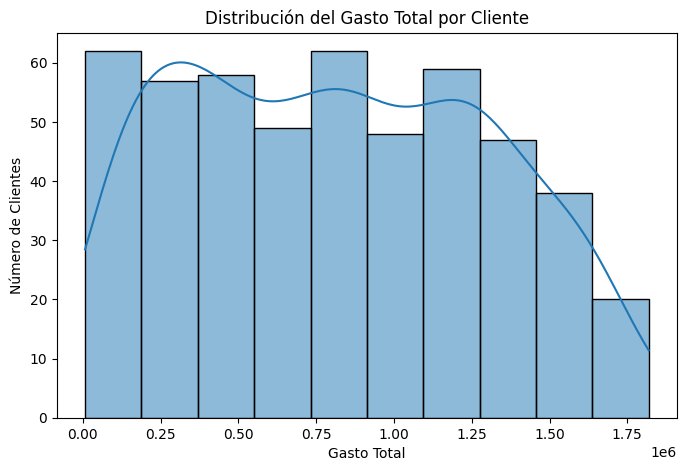

In [9]:
#histograma para Monetario_Total
plt.figure(figsize=(8, 5))
sns.histplot(df_clientes_rfm['Monetario_Total'], kde=True)
plt.title('Distribución del Gasto Total por Cliente')
plt.xlabel('Gasto Total')
plt.ylabel('Número de Clientes')
plt.show()
# Haz lo mismo para Recencia y Frecuencia

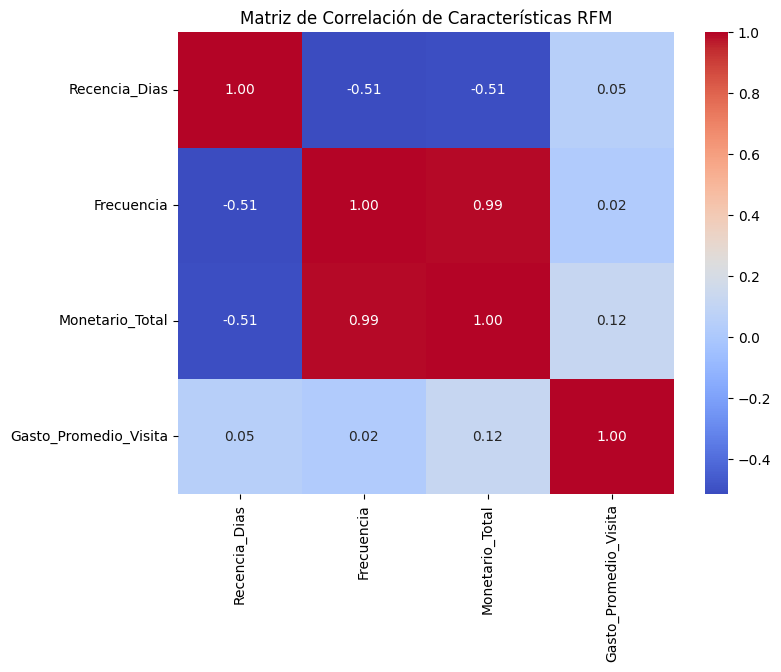

In [14]:
plt.figure(figsize=(8, 6))
sns.heatmap(df_clientes_rfm[['Recencia_Dias', 'Frecuencia', 'Monetario_Total', 'Gasto_Promedio_Visita']].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de Correlación de Características RFM')
plt.show()

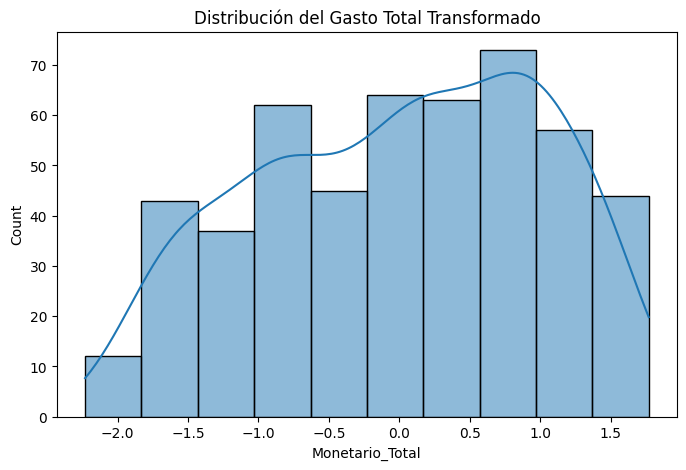


Primeras 5 filas del DataFrame RFM escalado:
   Recencia_Dias  Frecuencia  Monetario_Total  Gasto_Promedio_Visita
0       1.142444   -1.562606        -1.506512               0.711701
1       0.618144   -0.837719        -0.707726               0.857889
2      -0.007867    0.986145         0.933888              -0.150806
3       0.794461   -1.562606        -1.535636               0.238515
4      -1.312893    0.700392         0.498724              -0.792874


In [15]:

from sklearn.preprocessing import StandardScaler, PowerTransformer # PowerTransformer puede ayudar con el sesgo

# --- 1. Tratar el Sesgo (Ejemplo con Logaritmo o PowerTransformer) ---
# Copia el DataFrame para no modificar el original directamente en este paso
df_rfm_transformado = df_clientes_rfm.copy()

# Características a transformar/escalar
features_to_scale = ['Recencia_Dias', 'Frecuencia', 'Monetario_Total', 'Gasto_Promedio_Visita']

#PowerTransformer (Yeo-Johnson o Box-Cox)
# Yeo-Johnson puede manejar datos positivos, cero y negativos. Box-Cox solo positivos.
pt = PowerTransformer(method='yeo-johnson') # 'box-cox' si todos los datos son estrictamente positivos
df_rfm_transformado[features_to_scale] = pt.fit_transform(df_rfm_transformado[features_to_scale])

# Visualiza los histogramas de las características transformadas para ver si el sesgo disminuyó
# Ejemplo para Monetario_Total transformado
plt.figure(figsize=(8, 5))
sns.histplot(df_rfm_transformado['Monetario_Total'], kde=True)
plt.title('Distribución del Gasto Total Transformado')
plt.show()

# --- 2. Escalar los Datos (usando las características transformadas) ---
scaler = StandardScaler()
df_rfm_escalado_array = scaler.fit_transform(df_rfm_transformado[features_to_scale])

# Convertir el array escalado de nuevo a un DataFrame (opcional, pero útil para inspeccionar)
df_rfm_escalado = pd.DataFrame(df_rfm_escalado_array, columns=features_to_scale)

print("\nPrimeras 5 filas del DataFrame RFM escalado:")
print(df_rfm_escalado.head())